In [200]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import yaml
import zipfile

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from chspy import CubicHermiteSpline

# os.chdir(Path(os.getcwd()).parent)
from assistive_arm.utils.data_preprocessing import prepare_opencap_markers, smooth_dataframe, interpolate_dataframe
from assistive_arm.utils.optimum_length_utils import compute_torque_profiles, get_rotation_matrix, check_theta
from assistive_arm.utils.plotting import create_torque_plot

## Read data

### Marker data

In [202]:
subject = "subject_1"
subject_data = Path("/Users/xabieririzar/Desktop/Life/Studium/TUM/Master_Robotics/Harvard/Thesis/subject_testing/subject_data/") / subject
trial = subject_data / "trial_2"

project_moco_data = Path("/Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/")
control_solutions = project_moco_data / "control_solutions"

# Set directories
opencap_markers = pd.read_csv(trial / "opencap_tracker.trc", delimiter="\t", skiprows=3).tail(-1)
filtered_markers = prepare_opencap_markers(opencap_markers)

# Read solution and yaml config
solution_path = control_solutions / "opencap_simple_assistance_false_2023-09-22_17-13.sto"
control_solution = pd.read_csv(solution_path, delimiter="\t", skiprows=18)
config_path = control_solutions / f"{solution_path.stem}.yaml"

try:
    with open(config_path, "r") as f:
        config_file = yaml.load(f, Loader=yaml.FullLoader)
except FileNotFoundError:
    print(f"No config file found at {config_path}")


No config file found at /Users/xabieririzar/uni-projects/Harvard/assistive-arm/moco/control_solutions/opencap_simple_assistance_false_2023-09-22_17-13.yaml


### Load motor data

In [203]:
motor_config = Path('/Users/xabieririzar/uni-projects/Harvard/assistive-arm/motor_config.yaml')
with open(motor_config, 'r') as f:
    motor_config = yaml.load(f, Loader=yaml.FullLoader)

### Get pelvis marker and set it as human anchoring position

In [204]:
pelvis_x = (filtered_markers["r.PSIS_study"].X + filtered_markers["L.PSIS_study"].X)/2 
pelvis_y = (filtered_markers["r.PSIS_study"].Y + filtered_markers["L.PSIS_study"].Y)/2
pelvis_z = (filtered_markers["r.PSIS_study"].Z + filtered_markers["L.PSIS_study"].Z)/2 

pelvis_marker = pd.DataFrame({"Time": filtered_markers.Time.t, "X": pelvis_x, "Y": pelvis_y, "Z": pelvis_z})
pelvis_marker = pelvis_marker[(pelvis_marker.Time >= 1.8) & (pelvis_marker.Time <= 3.2)].reset_index(drop=True)
pelvis_marker.set_index("Time", inplace=True)
new_index = pd.Index(np.arange(pelvis_marker.index.min(), pelvis_marker.index.max() + 0.025, step=0.025), name="Time")
pelvis_marker_aligned = pelvis_marker.reindex(new_index, method="nearest")
pelvis_marker_aligned = smooth_dataframe(pelvis_marker_aligned, window_size=5)


### Read assistive force profile

In [205]:
assistive_force = control_solution[["time", "/forceset/reserve_jointset_ground_pelvis_pelvis_tx", "/forceset/reserve_jointset_ground_pelvis_pelvis_ty"]]
assistive_force.set_index("time", inplace=True)
assistive_force.columns = ["X", "Y"]
assistive_force.insert(2, "Z", 0)

# Scale down force profile
assistive_force *= 100
assistive_force *= 2/3

## Calculate optimal link length ratio

### Get distance vector from pelvis to anchor point

In [206]:
chair_position = np.array([-0.6, 0.5, -0.075])
pelvis_to_chair = chair_position - pelvis_marker_aligned

print(f"Anchoring point on bench: {pelvis_to_chair.X.iloc[0]:.3f}m away from pelvis")

Anchoring point on bench: -0.245m away from pelvis


### Calculate optimal length

In [207]:
min_necessary_length = np.linalg.norm(pelvis_to_chair, axis=1).max()

print("Minimum total length: ", min_necessary_length)

resolution = 30

link_lengths_1 = np.linspace(0.1, 1, resolution)
link_lengths_2 = np.linspace(0.1, 1, resolution)
link_lengths_1 = link_lengths_1[link_lengths_1 < min_necessary_length]
link_lengths_2 = link_lengths_2[link_lengths_2 < min_necessary_length]

# Set joint angle limits (degrees)
theta_1_lims = np.deg2rad([0, 180])
theta_2_lims = np.deg2rad([-145, 145])

results = []

for l1 in link_lengths_1:
    for l2 in link_lengths_2:
        if l1 + l2 < min_necessary_length:
            continue
        
        torques, joint_angles, jacobians = compute_torque_profiles(l1, l2, F=assistive_force, position=pelvis_to_chair)

        # Don't include invalid values
        if np.any(np.isnan(torques)) or np.any(np.isnan(joint_angles)):
            continue

        result = {
            'l1': l1,
            'l2': l2,
            'tau_1': torques.tau_1,
            'tau_2': torques.tau_2,
            'theta_1': joint_angles.theta_1,
            'theta_2': joint_angles.theta_2,
            'jacobians': jacobians,
        }
        results.append(result)

Minimum total length:  0.8394251723955564


### Filter out infeasible torque profiles

In [208]:
feasible_profiles = pd.DataFrame(results)
feasible_profiles.dropna(inplace=True)

# Filter out solutions that are outside of the joint angle limits
feasible_profiles = feasible_profiles[feasible_profiles["theta_1"].apply(check_theta, theta_lims=theta_2_lims) & feasible_profiles["theta_2"].apply(check_theta, theta_lims=theta_2_lims)]

### Get ideal torque combination

In [209]:
# Get link lengths that minimizes the peak torque for both motors
torques = feasible_profiles[["tau_1", "tau_2"]].map(lambda x: np.abs(x).max())
min_overall_torque = np.linalg.norm(torques, axis=1)
min_torque_loc = min_overall_torque.argmin()

In [210]:
l1, l2, tau_1, tau_2, theta_1, theta_2, jacobians = feasible_profiles.iloc[min_torque_loc]

optimal_profile = pd.DataFrame({'theta_1': theta_1.to_numpy(), 'theta_2': theta_2.to_numpy()}, index=theta_1.index)

### Calculate necessary bar length based on offset from rotational axis and link inserts

In [211]:
bar_1 = l1 - 0.103 # Constants based on CAD model (dist from bar to rot axis)
bar_2 = l2 - 0.081125
print(f"Bar 1: {bar_1:.3f} m")
print(f"Bar 2: {bar_2:.3f} m")

Bar 1: 0.338 m
Bar 2: 0.360 m


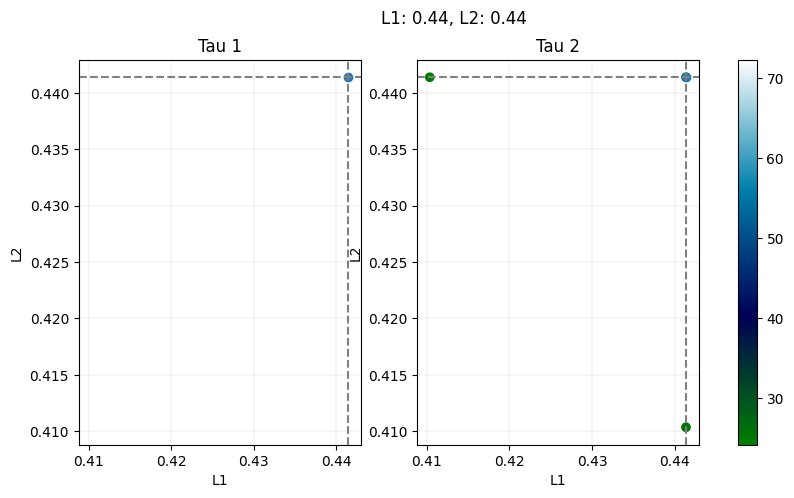

In [212]:
create_torque_plot(torques=torques, feasible_profiles=feasible_profiles, l1=l1, l2=l2)

### Calculate End Effector and Elbow trajecotries based on optimal link length

In [213]:
rotate_90 = get_rotation_matrix(90)

P_EE = np.array([l1*np.cos(theta_1) + l2*np.cos(theta_1 + theta_2), l1*np.sin(theta_1) + l2*np.sin(theta_1 + theta_2)])
P_L1 = np.array([l1*np.cos(theta_1), l1*np.sin(theta_1)])

P_L1 = pd.DataFrame(P_L1.T, columns=["X", "Y"], index=theta_1.index)
P_EE = pd.DataFrame(P_EE.T, columns=["X", "Y"], index=theta_1.index)
P_EE.columns = ["X", "Y"]
P_L1.columns = ["X", "Y"]

In [214]:
optimal_profile['EE_X'] = P_EE.X
optimal_profile['EE_Y'] = P_EE.Y

In [215]:
motion_percentage = (optimal_profile.index - optimal_profile.index.min())/(optimal_profile.index.max() - optimal_profile.index.min()) * 100

### Interpolate and smooth profiles

In [216]:
interpol_force_profile = interpolate_dataframe(df=assistive_force, desired_frequency=200)
interpol_force_profile = smooth_dataframe(df=interpol_force_profile, window_size=5)
optimal_profile = interpolate_dataframe(df=optimal_profile, desired_frequency=200)
optimal_profile = smooth_dataframe(df=optimal_profile, window_size=5)

pelvis_to_chair_smoothed = smooth_dataframe(interpolate_dataframe(df=pelvis_to_chair), window_size=5)

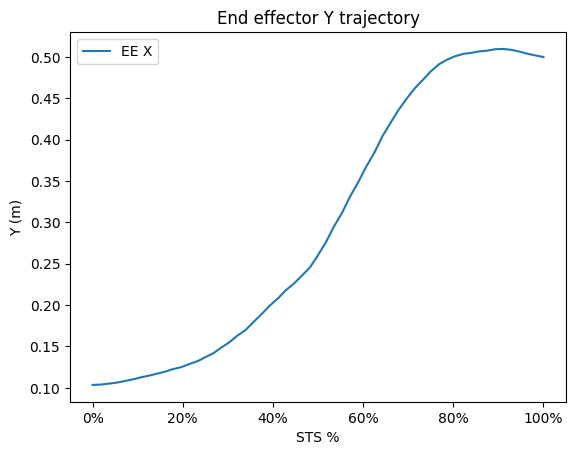

In [217]:
plt.plot(motion_percentage, -P_EE.X, label='EE X')
plt.grid()
plt.xlabel("STS %")
plt.ylabel("Y (m)")
plt.title("End effector Y trajectory")
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
plt.show()

In [218]:
theta_1_dot = np.gradient(optimal_profile.theta_1) / interpol_force_profile.index.diff()
theta_2_dot = np.gradient(optimal_profile.theta_2) / interpol_force_profile.index.diff()

### Modify optimal profile

In [219]:
# Change index to motion percentage
motion_percentage = (optimal_profile.index - optimal_profile.index.min())/(optimal_profile.index.max() - optimal_profile.index.min()) * 100

optimal_profile.set_index(motion_percentage, inplace=True)
optimal_profile.index.name = "Percentage"

In [220]:
modified_force_profile = interpol_force_profile.copy()

zero_points = np.where(np.isclose(modified_force_profile.Y, 0, atol=4))[0]
profile_end = zero_points[1]
modified_force_profile.iloc[profile_end:, :] = 0
modified_force_profile.iloc[:, [0, 2]] = 0

Text(0.5, 1.0, 'Assistive force profile')

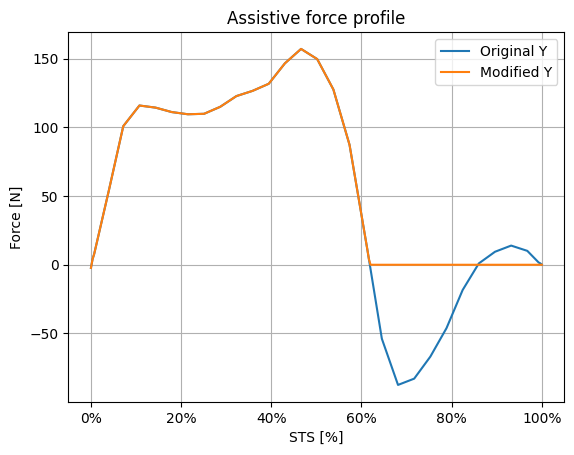

In [221]:
plt.plot(motion_percentage, interpol_force_profile.Y, label='Original Y')
plt.plot(motion_percentage, modified_force_profile.Y, label='Modified Y')
plt.xlabel("STS [%]")
plt.ylabel("Force [N]")
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
plt.grid()
plt.legend()
plt.title("Assistive force profile")

In [222]:
torques, angles, jacobians =  compute_torque_profiles(l1=l1, l2=l2, F=modified_force_profile, position=pelvis_to_chair_smoothed)


### Scale profiles to a set MIN/MAX range

In [223]:
# Scale the torque profiles
scale_factor_tau1 = motor_config["AK70-10"]['T_max'] / np.abs(torques.tau_1).max()
scale_factor_tau2 = motor_config["AK60-6"]['T_max'] / np.abs(torques.tau_2).max()
# Scaling torque profiles
print(f"Scaling factor tau1: {scale_factor_tau1:.3f}")
print(f"Scaling factor tau2: {scale_factor_tau2:.3f}")

print("Scaling everything by tau_1 to keep the same ratio")
optimal_profile["tau_1"] = torques.tau_1.to_numpy() * scale_factor_tau1
optimal_profile["tau_2"] = torques.tau_2.to_numpy() * scale_factor_tau1

Scaling factor tau1: 0.394
Scaling factor tau2: 1.188
Scaling everything by tau_1 to keep the same ratio


### Recalculate force based on scaled torques

In [224]:
torques = optimal_profile[["tau_1", "tau_2"]].to_numpy()
N, M = torques.shape
torques = torques.reshape(N, M, 1)

# Inverse operation for getting force profile from torques
F = - rotate_90[:2, :2] @ np.linalg.inv(jacobians.T) @ torques

optimal_profile['force_X'] = F[:, 0]
optimal_profile['force_Y'] = F[:, 1]

ee_curve = optimal_profile['EE_X']

for i, x in enumerate(ee_curve):
    if i == 0:
        continue
    if x > ee_curve.iloc[i-1]:
        ee_curve.iloc[i] = ee_curve.iloc[i-1]

In [225]:
def f_prof(params: list, n: int):
    spline = CubicHermiteSpline(n=1)
    spline.add((-1, [0], [0]))  # init pt
    spline.add((params[0], [params[1]], [0]))  # first peak
    spline.add((params[2] * n, [0], [0]))  # point at 90% of N where value becomes 0
    spline.add((n, [0], [0]))  # ensure spline remains at 0 after 90% of N
    return spline

In [226]:
peak_force = optimal_profile.force_Y.max()
peak_time_index = optimal_profile.force_Y.argmax()

# Generate curves in range 20-80% of N
peak_force_jump = N * 0.1 # 10% of N

peak_time_indices = []

for i in range(-10, 10, 1):
    new_ind = int(peak_time_index + peak_force_jump * i)

    if new_ind < 0 or new_ind > N:
        continue
    
    new_percent = motion_percentage[new_ind]
    if new_percent > 20 and new_percent < 80:
        peak_time_indices.append(new_ind)

peak_force_values = [peak_force*(1-0.1*i) for i in range(5)]

In [257]:
splines = {}
zero_at = 0.95

for peak_time_index in peak_time_indices:
    peak_time = round(motion_percentage[peak_time_index]) # Actual percentage value
    splines[peak_time] = []

    for peak_force in peak_force_values:
        params = [peak_time_index, peak_force, zero_at]
        grf = f_prof(params, N)

        spline = []
        
        for i in range(N):
            spline.append(grf.get_state(i)[0])
        spline = pd.DataFrame.from_dict(
            {"Time": modified_force_profile.index,
            "X": 0,
            "Y": spline,
            "Z": 0}
        )
        spline.set_index("Time", inplace=True)

        torques, _, _ =  compute_torque_profiles(l1=l1, l2=l2, F=spline, position=pelvis_to_chair_smoothed)
        spline_profile = optimal_profile.copy()
        spline_profile[["force_X", "force_Y"]] = spline[["X", "Y"]].to_numpy()
        spline_profile[["tau_1", "tau_2"]] = torques.to_numpy()
        splines[peak_time].append(spline_profile)

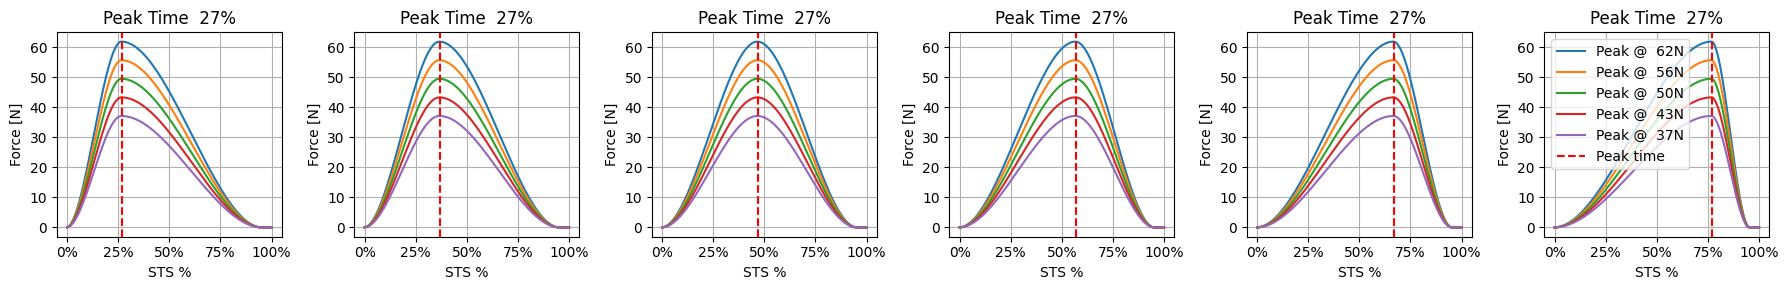

In [256]:
n_rows = len(splines.keys())
fig, axs = plt.subplots(1, n_rows, figsize=(n_rows*3, 3))  # Adjust the figure size as needed

for i, (peak_time, same_peak_time_splines) in enumerate(splines.items()):
    for peak_force_spline in same_peak_time_splines:
        # Assuming each spline object can be plotted directly
        axs[i].plot(motion_percentage, peak_force_spline.force_Y, label=f'Peak @ {peak_force_spline.force_Y.max(): .0f}N')  # Replace .id with an appropriate identifier
    axs[i].axvline(x=peak_time, color='r', linestyle='--', label='Peak time')
    axs[i].set_title(f'Peak Time {motion_percentage[peak_time_index]: .0f}%')
    axs[i].grid()
    axs[i].xaxis.set_major_formatter(mticker.PercentFormatter())
    axs[i].set_xlabel("STS %")
    axs[i].set_ylabel("Force [N]")
    if i == n_rows - 1:
        axs[i].legend()

plt.tight_layout()
plt.show()

### Transfer profile to Raspberry Pi

In [263]:
spline_paths = []

for peak_time, same_peak_time_splines in splines.items():
    for peak_force_spline in same_peak_time_splines:
        spline_path = f"../torque_profiles/peak_time_{peak_time:.0f}_peak_force_{peak_force_spline.force_Y.max():.0f}.csv"
        spline_paths.append(spline_path)
        peak_force_spline.to_csv(spline_path)

In [ ]:
optimal_profile_path = trial / "simulation_profile.csv"
optimal_profile.to_csv(optimal_profile_path)
optimal_profile.to_csv("../torque_profiles/simulation_profile.csv")

In [283]:
timeout_limit = 5 #s

command = f"timeout {timeout_limit} scp {str(optimal_profile_path)} ABILITY_LAB_WLAN:/home/xabier/ability-lab/assistive-arm/torque_profiles/"
os.system(command)

zip_file_path = Path("../torque_profiles/spline_profiles.zip").absolute()
with zipfile.ZipFile(zip_file_path, "w") as zip_file:
    for spline_path in spline_paths:
        zip_file.write(spline_path, os.path.basename(spline_path))
command = f"scp {zip_file_path} ABILITY_LAB_WLAN:/home/xabier/ability-lab/assistive-arm/torque_profiles/"
os.system(command)

unzip_command = f"ssh ABILITY_LAB_WLAN 'unzip -oq /home/xabier/ability-lab/assistive-arm/torque_profiles/spline_profiles.zip -d /home/xabier/ability-lab/assistive-arm/torque_profiles/spline_profiles/'"
os.system(unzip_command)
exit_status = os.system("ssh ABILITY_LAB_WLAN 'rm /home/xabier/ability-lab/assistive-arm/torque_profiles/spline_profiles.zip'")
# Execute the command

# Check if the command timed out or failed
if exit_status != 0:
    if exit_status == 31744:
        print(f"Timeout: The file copy operation did not complete within {timeout_limit} seconds.")
    else:
        print(f"An error occurred with exit status {exit_status}.")

## Plot profiles and EE trajectory

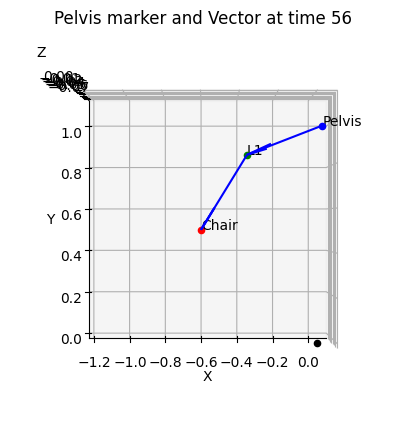

In [ ]:
rotate_90 = get_rotation_matrix(90)

P_EE['Z'] = 0
P_L1['Z'] = 0

timestep = 56
plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.view_init(azim=-90, elev=90)

pelvis_pos = pelvis_marker_aligned.iloc[timestep]
pelvis_chair = pelvis_to_chair.iloc[timestep].T

l1_vector = rotate_90 @ P_L1.iloc[timestep].T
l1_origin = pelvis_pos
l1_pos = pelvis_pos + l1_vector

l2_pos = rotate_90 @ P_EE.iloc[timestep].T
l2_origin = l1_pos
l2_vector = l2_pos - l1_vector

ee_pos = pelvis_pos + l2_pos

ax.scatter(*pelvis_pos, color="b")
ax.text(*pelvis_pos, "Pelvis")

ax.scatter(*l1_pos, color="g")
ax.text(*l1_pos, "L1")

ax.scatter(*chair_position, color="r")
ax.text(*chair_position, "Chair")

origin = [0, 0, 0]
ax.scatter(*origin, color="k")

# ax.quiver(*pelvis_pos, *pelvis_chair, color="b")
ax.quiver(*l1_origin, *l1_vector, color="b")
ax.quiver(*l2_origin, *l2_vector, color="b")
ax.set_xlim([-1.2, pelvis_marker_aligned.X.max()])
ax.set_ylim([0, 1.1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pelvis marker and Vector at time {}'.format(timestep))

plt.show()

Text(0, 0.5, 'rad/s')

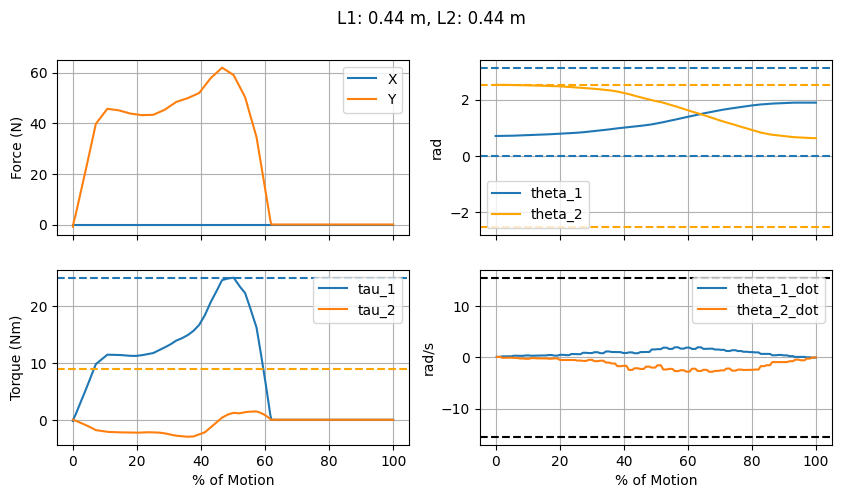

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True)
fig.suptitle(f"L1: {float(l1):.2f} m, L2: {float(l2):.2f} m")
axs[0, 0].plot(motion_percentage, optimal_profile[['force_X', 'force_Y']])
axs[0, 0].set_ylabel("Force (N)")
axs[0, 0].legend(["X", "Y", "Z"])
axs[0, 0].grid()

axs[1, 0].plot(motion_percentage, optimal_profile.tau_1, label="tau_1")
axs[1, 0].axhline(y=motor_config["AK70-10"]['T_max'], linestyle="--", color="C0")
axs[1, 0].plot(motion_percentage, optimal_profile.tau_2, label="tau_2")
axs[1, 0].axhline(y=motor_config["AK60-6"]['T_max'], linestyle="--", color="orange")
axs[1, 0].legend()
axs[1, 0].set_xlabel("% of Motion")
axs[1, 0].set_ylabel("Torque (Nm)")
axs[1, 0].grid()

axs[0, 1].plot(motion_percentage, optimal_profile.theta_1, label="theta_1", color="C0")
axs[0, 1].axhline(y=theta_1_lims[0], linestyle="--", color="C0")
axs[0, 1].axhline(y=theta_1_lims[1], linestyle="--", color="C0")
axs[0, 1].plot(motion_percentage, optimal_profile.theta_2, label="theta_2", color="orange")
axs[0, 1].axhline(y=theta_2_lims[0], linestyle="--", color="orange")
axs[0, 1].axhline(y=theta_2_lims[1], linestyle="--", color="orange")
axs[0, 1].legend()
axs[0, 1].set_ylabel("rad")
axs[0, 1].grid()

# Add dashed line for max rad/s with label
axs[1, 1].plot(motion_percentage, theta_1_dot, label="theta_1_dot")
axs[1, 1].plot(motion_percentage, theta_2_dot, label="theta_2_dot")
axs[1, 1].axhline(y=15.5, linestyle="--", color="k")
axs[1, 1].axhline(y=-15.5, linestyle="--", color="k")
axs[1, 1].grid()
axs[1, 1].legend()
axs[1, 1].set_xlabel("% of Motion")
axs[1, 1].set_ylabel("rad/s")